<a href="https://colab.research.google.com/github/maharanicintaa/maharani.github.io/blob/master/bismillah_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIPIPIP Install

In [ ]:
pip install pyproj

In [ ]:
pip install rasterio

In [ ]:
pip install earthpy

In [ ]:
pip install geopandas

In [ ]:
pip install rioxarray

# Import Library

In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from rasterio.plot import show
import pandas as pd
from google.colab import drive

In [ ]:
import rasterio as rio
import rasterio.plot as rioplot
import rioxarray as rxr
import pyproj
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask

In [ ]:
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy as et

In [ ]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
import pyproj

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.ndimage import generic_filter

# Mounting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("drive/MyDrive/ipynb/data_coba")

In [ ]:
os.getcwd()

'/content/drive/MyDrive/ipynb/data_coba'

Import File

In [ ]:
# SHP
WPPRI = gpd.read_file("WPPRI711.shp")

In [ ]:
# Reprojection
WPPRI.crs = 'EPSG:32748'

In [ ]:
WPPRI.crs

<Projected CRS: EPSG:32748>
Name: WGS 84 / UTM zone 48S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 102°E and 108°E, southern hemisphere between 80°S and equator, onshore and offshore. Indonesia.
- bounds: (102.0, -80.0, 108.0, 0.0)
Coordinate Operation:
- name: UTM zone 48S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<Axes: >

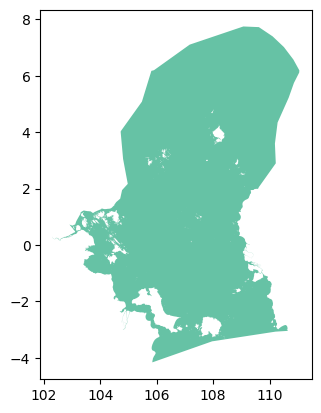

In [ ]:
WPPRI.plot(cmap='Set2')

In [ ]:
# RASTER
PFZ = "PFZ_COBA.tif"
VMS = "VMS_COBA.tif"

In [ ]:
#Reprojection, convert ke EPSG
PFZ_COBA_crs = 'EPSG:32748'
VMS_COBA_crs = 'EPSG:32748'

In [ ]:
#cek metadata
print(PFZ_COBA_crs)
print(VMS_COBA_crs)
print (WPPRI.crs)

EPSG:32748
EPSG:32748
EPSG:32748


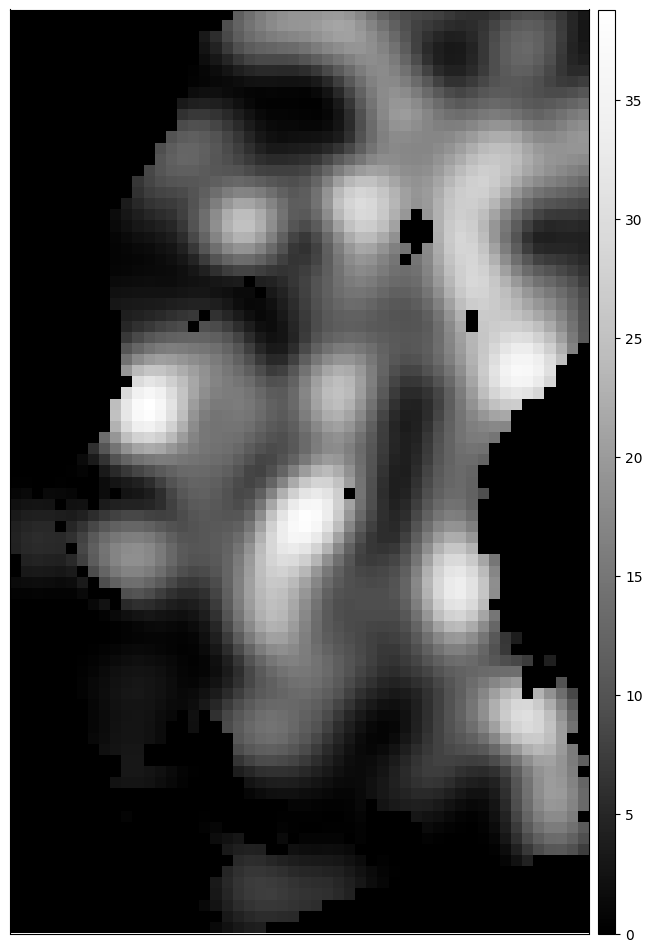

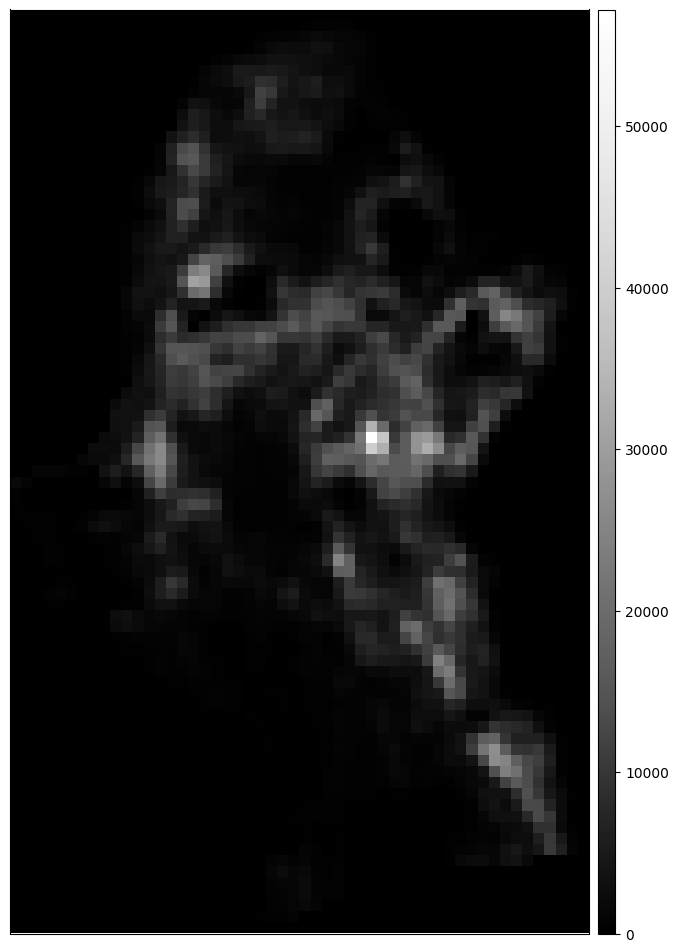

<Axes: >

In [ ]:
ep.plot_bands(PFZ_COBA)
ep.plot_bands(VMS_COBA)

# Calculating correlation

In [ ]:
# Function to read raster and return array + metadata
def read_raster(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Read first band
        profile = src.profile  # Save metadata
    return data, profile

In [ ]:
# File paths
raster1_path = "PFZ_COBA.tif"
raster2_path = "VMS_COBA.tif"

# Read raster data
PFZ_COBA, profile = read_raster(raster1_path)
VMS_COBA, _ = read_raster(raster2_path)

In [ ]:
# Ensure rasters have same shape
if PFZ_COBA.shape != VMS_COBA.shape:
    raise ValueError("Rasters must have the same dimensions.")

In [ ]:
valid_mask = (PFZ_COBA != 0) & (VMS_COBA != 0)  # Mask pixels where both are non-zero

PFZ_COBA_filtered = np.where(valid_mask, PFZ_COBA, np.nan)
VMS_COBA_filtered = np.where(valid_mask, VMS_COBA, np.nan)

In [ ]:
# Function to compute correlation in a moving window
def moving_correlation(window):
    size = window.size // 3
    x, y = window[:size], window[size:]

    # Ignore if all values are NaN
    if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        return np.nan

    # Compute Pearson correlation
    return pearsonr(x, y)[0]

In [ ]:
# Stack the two rasters to apply the filter
stacked_data = np.dstack((PFZ_COBA_filtered, VMS_COBA_filtered))
window_size = 3  # Define kernel size (3x3)

In [ ]:
 # Function to compute correlation in a moving window
def moving_correlation(window):
    # Ensure the window is divided into two halves for correlation
    size = window.size // 3  # Split the window size into two equal parts

    if window.size % 2 == 1:
        center = window[window.size // 2]
        x, y = window[:size], window[size + 1:]  # Skip the center element
    else:
        x, y = window[:size], window[size:]
# Ensure x and y have the same length
    if len(x) != len(y):
        return np.nan

In [ ]:
# Apply the moving correlation filter
correlation_raster = generic_filter(
    stacked_data,
    function=moving_correlation,
    size=(window_size, window_size, 1),  # Use 3x3 window
    mode='constant',  # Padding with NaN for the edges
    cval=np.nan  # Fill the padding with NaN
)

In [ ]:
print(f"Shape of correlation_raster: {correlation_raster.shape}")


Shape of correlation_raster: (83, 52, 2)


In [ ]:
# Extract only the first channel of the correlation result
correlation_raster = correlation_raster[:, :, 0]  # Selecting the first channel (correlation result)

# Check the shape after reshaping
print(f"Shape of the correlation raster after reshaping: {correlation_raster.shape}")

# Save the correlation raster
output_path = "correlation_raster.tif"
profile.update(dtype=rasterio.float32, count=1)  # We have one output band

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(correlation_raster.astype(rasterio.float32), 1)  # Save as a single band

print(f"Correlation raster saved as {output_path}")

Shape of the correlation raster after reshaping: (83, 52)
Correlation raster saved as correlation_raster.tif


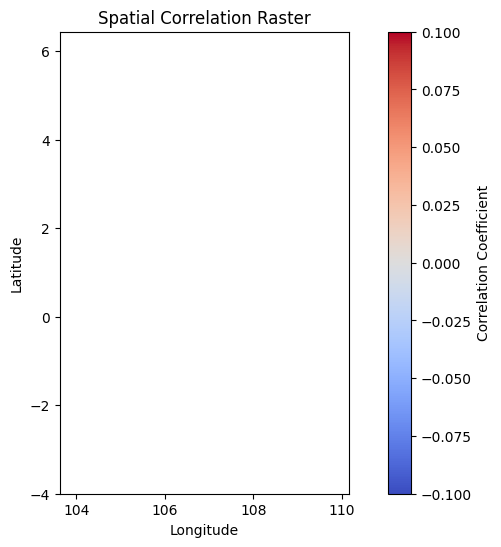

In [ ]:
# Read the correlation raster for visualization
with rasterio.open(output_path) as src:
    correlation_data = src.read(1)  # Read first band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Get spatial extent

# Plot the correlation raster
plt.figure(figsize=(10, 6))
plt.imshow(correlation_data, cmap="coolwarm", extent=extent, origin="upper")
plt.colorbar(label="Correlation Coefficient")
plt.title("Spatial Correlation Raster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

==========BATAS SUCI===============

In [ ]:

# Function to read raster and return array + metadata
def read_raster(raster_path):
    with rasterio.open(raster_path) as src:
        data = src.read(1)  # Read first band
        profile = src.profile  # Save metadata
    return data, profile

# File paths
raster1_path = "raster1.tif"
raster2_path = "raster2.tif"

# Read raster data
raster1, profile = read_raster(raster1_path)
raster2, _ = read_raster(raster2_path)

# Ensure rasters have same shape
if raster1.shape != raster2.shape:
    raise ValueError("Rasters must have the same dimensions.")

# Function to compute correlation in a moving window
def moving_correlation(window):
    size = window.size // 2
    x, y = window[:size], window[size:]

    # Ignore if all values are NaN
    if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        return np.nan

    # Compute Pearson correlation
    return pearsonr(x, y)[0]

# Stack the two rasters to apply the filter
stacked_data = np.dstack((raster1, raster2))
window_size = 3  # Define kernel size (3x3)

# Apply the moving window correlation
correlation_raster = generic_filter(
    stacked_data.reshape((raster1.shape[0], raster1.shape[1] * 2)),
    function=moving_correlation,
    size=(window_size, window_size * 2),
    mode="constant",
    cval=np.nan
)

# Save the correlation raster
output_path = "correlation_raster.tif"
profile.update(dtype=rasterio.float32, count=1)

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(correlation_raster.astype(rasterio.float32), 1)

print(f"Correlation raster saved as {output_path}")

# Read the correlation raster for visualization
with rasterio.open(output_path) as src:
    correlation_data = src.read(1)  # Read first band
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Get spatial extent

# Plot the correlation raster
plt.figure(figsize=(10, 6))
plt.imshow(correlation_data, cmap="coolwarm", extent=extent, origin="upper")
plt.colorbar(label="Correlation Coefficient")
plt.title("Spatial Correlation Raster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()